# Clasificación del nivel de deficiencia de fósforo en plantas de maíz
Conocer el estado nutricional de un cultivo es un factor crucial para determinar su productividad. Para abordar la identificación oportuna de trastornos nutricionales, este estudio se centra en la clasificación de tres niveles de deficiencias de fósforo mediante el análisis de hojas individuales de plantas de maíz.
El flujo de trabajo es el siguiente:
1. Se usa VGG16 preentrenada en ImageNet solo como extractor de características, reemplazando la capa final con un  Global Average Pooling (GAP) para obtener vector por imágen con su respectiva etiqueta. 
2. Se entrena modelos tabulares con LightGBM para usar como cabeza de clasificación 
3. Se evalúa el desempeño del modelo


# Carga y preparación de los datos
Se utiliza la base de datos [Maize Phosphorus Leaf Deficiency (MPLD) Database](https://zenodo.org/records/10279042), asumiendo que se han descargado de forma local y descomprimido la carpeta Processed_dataset.rar. Conservar la carpeta 'ThorCam_semiFiltered' 

In [23]:
# Carga de librerías
import os
import torch
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
#import pytorch_lightning as pl
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
#import shutil
from torch import nn
#import torch.optim as optim
#import torch.nn.functional as F
import torchvision.models as models
#from torchmetrics.classification import Accuracy
#from pytorch_lightning import Trainer
#from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

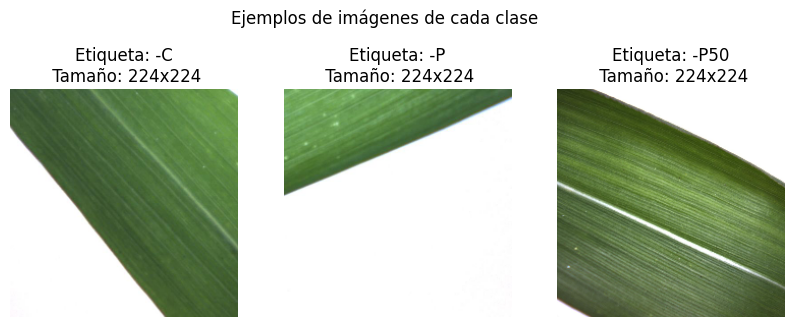

In [25]:
# Ruta de la carpeta que contiene las imágenes
path = 'D:/Universidad/MsC/VA/Talleres/ThorCam_semiFiltered/'
class_names = os.listdir(path)

# Graficar muestras de cada clase
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
fig.suptitle('Ejemplos de imágenes de cada clase')

for ax_row, class_name in zip(ax, class_names):
    # Obtener la ruta de la carpeta de la clase
    class_path = os.path.join(path, class_name)
    
    # Obtener una imagen aleatoria de la carpeta
    image_name = np.random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, image_name)
    
    # Cargar y mostrar la imagen
    image = Image.open(image_path).convert('RGB')
    # Tamaño de la imagen
    image_size = image.size
    ax_row.imshow(image)
    ax_row.set_title(f'Etiqueta: {class_name}\n Tamaño: {image_size[0]}x{image_size[1]}')
    ax_row.axis('off')
plt.show()

Antes de continuar con el modelado, es adecuado hacer un análisis exploratorio inicial para entender cómo están distribuidos los datos, considerando el preprocesamiento que tienen las imágenes, donde puede haber algunas donde el fondo blanco ocupa una mayor proporción en la imagen que la misma hoja. Vamos a verificar esto mediante histogramas en espacio HSV y un conteo de proporción de píxeles blancos.

Procesando -P50: 100%|██████████| 1260/1260 [00:06<00:00, 194.45it/s]


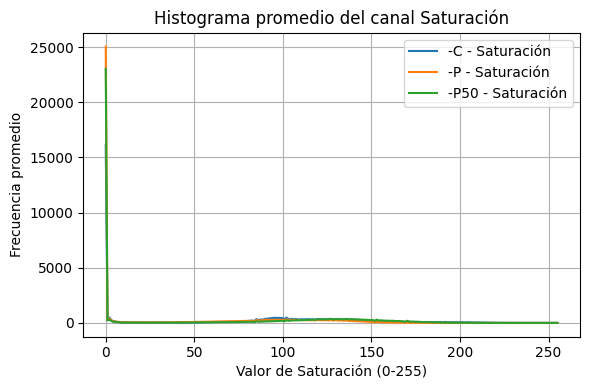

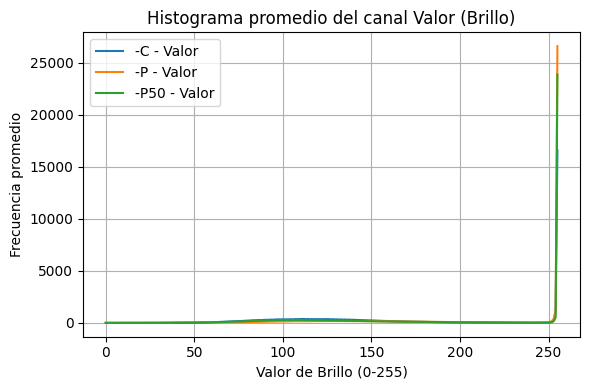


Porcentaje promedio de píxeles blancos por clase (basado en HSV):
-C: 36.00%
-P: 54.09%
-P50: 48.71%


In [3]:
# Ruta del dataset (con las subcarpetas -P, -P50, -C)
DATASET_DIR = path

# Bins para histogramas (0–255)
NUM_BINS = 256

# Umbrales para considerar un píxel "blanco" en HSV (se usa este espacio de color por conveniencia)
# Se considera solo los canales S y V
SAT_WHITE_THRESHOLD = 25
VAL_WHITE_THRESHOLD = 240

# Diccionarios para guardar resultados
hist_saturacion = {}
hist_valor = {}
porcentaje_blanco = {}

# Se recorre cada clase en el dataset
for clase in os.listdir(DATASET_DIR):
    ruta_clase = os.path.join(DATASET_DIR, clase)
    hist_S_total = np.zeros(NUM_BINS)
    hist_V_total = np.zeros(NUM_BINS)
    suma_porcentaje_blanco = 0
    contador_imagenes = 0

    for nombre_imagen in tqdm(os.listdir(ruta_clase), desc=f'Procesando {clase}'):
        ruta_img = os.path.join(ruta_clase, nombre_imagen)
        try:
            # Cargar la imagen y convertirla a RGB
            img = Image.open(ruta_img).convert('RGB')
            img_np = np.array(img)

            # Convertir a HSV usando PIL (pasamos por float para precisión)
            img_hsv = img.convert('HSV')
            img_hsv_np = np.array(img_hsv)

            S = img_hsv_np[:, :, 1]
            V = img_hsv_np[:, :, 2]

            # Histogramas por canal
            hist_S, _ = np.histogram(S, bins=NUM_BINS, range=(0, 255))
            hist_V, _ = np.histogram(V, bins=NUM_BINS, range=(0, 255))

            hist_S_total += hist_S
            hist_V_total += hist_V

            # Porcentaje de píxeles blancos
            blancos = np.logical_and(S < SAT_WHITE_THRESHOLD, V > VAL_WHITE_THRESHOLD)
            porcentaje_blanco_imagen = blancos.sum() / blancos.size
            suma_porcentaje_blanco += porcentaje_blanco_imagen

            contador_imagenes += 1

        except Exception as e:
            print(f"Error en {ruta_img}: {e}")

    if contador_imagenes > 0:
        hist_saturacion[clase] = hist_S_total / contador_imagenes
        hist_valor[clase] = hist_V_total / contador_imagenes
        porcentaje_blanco[clase] = suma_porcentaje_blanco / contador_imagenes


# GRAFICAR HISTOGRAMAS

# Saturación
plt.figure(figsize=(6, 4))
for clase, hist in hist_saturacion.items():
    plt.plot(hist, label=f'{clase} - Saturación')
plt.title("Histograma promedio del canal Saturación")
plt.xlabel("Valor de Saturación (0-255)")
plt.ylabel("Frecuencia promedio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Valor
plt.figure(figsize=(6, 4))
for clase, hist in hist_valor.items():
    plt.plot(hist, label=f'{clase} - Valor')
plt.title("Histograma promedio del canal Valor (Brillo)")
plt.xlabel("Valor de Brillo (0-255)")
plt.ylabel("Frecuencia promedio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# PORCENTAJE DE BLANCOS

print("\nPorcentaje promedio de píxeles blancos por clase (basado en HSV):")
for clase, pct in porcentaje_blanco.items():
    print(f"{clase}: {pct*100:.2f}%")


Podemos observar de los histogramas que las clases -P y -P50 tienen un mayor conteo de valores blancos (valores bajos en Saturación y valores altos en Brillo) que la calse -C. Lo cual es evidente si uno recorre un poco el conjunto de datos y nota que hay varias imágenes que tienen un mayor contenido de fondo que de hoja. 

Es por esto que el mismo dataset tiene una marca para identificar las imágenes con alto contenido de píxeles blancos: un sufijo `_EMPTY` en el nombre del archivo.

## Data Generator
Los conjuntos de datos de Torch `Datasets` son abstracciones que manejan la carga y el preprocesamiento de datos. Normalmente son subclases de `torch.utils.data.Dataset` y definen dos métodos principales: `__len__` (devuelve el tamaño del conjunto de datos) y `__getitem__` (recupera una muestra de datos). Y se implementan a partir de listas o Dataframes que contengan los nombres y etiquetas de las muestras.

Vamos a usar la función `torchvision.datasets.ImageFolder` que es eficiente para cargar datasets estructurados por carpetas.

> 💡 Para resolver el problema de las imágenes con alto porcentaje de píxeles blancos, evitamos cargar las imágenes con el sufijo `_EMPTY` mediante un filtro. Para esto, creamos una sublcase de `ImageFolder`


In [26]:
# Transformaciones para el dataset
transform = transforms.Compose([ # compatibles con vgg
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class FilteredImageFolder(ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform=transform)

        # Filtrar las imágenes que NO contienen '_EMPTY' en su nombre
        self.samples = [s for s in self.samples if '_EMPTY' not in os.path.basename(s[0])]
        self.imgs = self.samples  # alias usado internamente



Número de clases: 3

Cantidad de imágenes por clase:
  Etiqueta  Cantidad
0     -P50       977
1       -C       935
2       -P       864

Número total de imágenes en el dataset: 2776


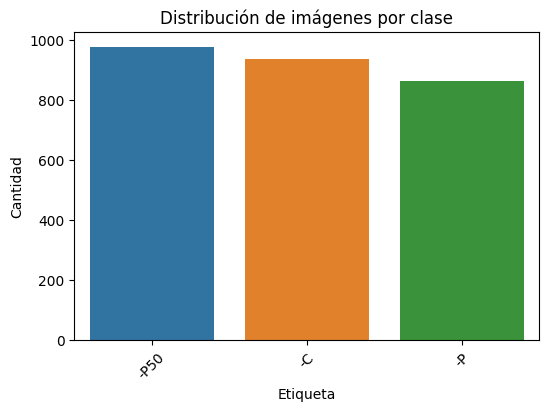


Etiquetas de clase mapeadas a índices (hecho de forma automática por ImageFolder):
{'-C': 0, '-P': 1, '-P50': 2}


In [29]:
# Creamos la estructura del dataset
dataset = FilteredImageFolder(root=path, transform=transform)

# Obtener las etiquetas de las imágenes
labels = [class_names[label] for _, label in dataset.samples]
# Crear un DataFrame con las etiquetas
df = pd.DataFrame(labels, columns=['Etiqueta'])
# Contar la cantidad de imágenes por clase
df_counts = df['Etiqueta'].value_counts().reset_index()
df_counts.columns = ['Etiqueta', 'Cantidad']
# Definir el numero de clases
num_classes = len(df_counts['Etiqueta'].unique())
print(f"\nNúmero de clases: {num_classes}")

# Imprmir la cantidad de imágenes por clase
print("\nCantidad de imágenes por clase:")
print(df_counts)
# Imprimir el número total de imágenes
print(f"\nNúmero total de imágenes en el dataset: {len(dataset)}")

# Graficar la distribución de clases
plt.figure(figsize=(6, 4))
sns.barplot(x='Etiqueta', y='Cantidad', data=df_counts, hue= 'Etiqueta')
plt.title('Distribución de imágenes por clase')
plt.xticks(rotation=45)
plt.show()

# Mapeo de las etiquetas a índices:
print("\nEtiquetas de clase mapeadas a índices (hecho de forma automática por ImageFolder):")
print(dataset.class_to_idx)

Podemos ver que la clase que más contenía imagenes de mayor proporción de píxeles blancos (`-P`) fue la que quedó con menor cantidad de datos. 

Por otra parte, aunque hay una desproporción en la distribución de imágenes, se considera que esta es muy baja para influir en el resultado de la clasificación.

## Data Loader
Torch cuenta con la clase `DataLoader`, que proporcionan un iterable sobre un objeto `Dataset`, permitiendo un procesamiento por lotes eficiente, barajando y cargando datos en paralelo. Se crea un `DataLoader` con todas las imágenes de Dataset, sin dividir inicialmente en conjuntos de entrenamiento y prueba, pues solo vamos a usar la red preentrenada como una función de transformación que convierte imágenes en vectores.

In [30]:
batch_size = 32
num_workers = 2

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Etapa 1: Extracción de vectores GAP

In [7]:
# Extraer un subconjunto del dataset para pruebas rápidas
from torch.utils.data import Subset
import numpy as np

# Fracción deseada (por ejemplo, 10%)
frac = 0.1
tam_subset = int(len(dataset) * frac)

# Seleccionar índices aleatorios
indices = np.random.choice(len(dataset), tam_subset, replace=False)
subset = Subset(dataset, indices)

# Crear DataLoader más pequeño
small_loader = DataLoader(subset, batch_size=batch_size, shuffle=False)

In [ ]:
# VGG16 carga el modelo VGG16 preentrenado
vgg = models.vgg16_bn(pretrained=True)
# Extrae solo la parte convolucional y la empaqueta
vgg_features = nn.Sequential(*list(vgg.features.children())) 
gap = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling
# Empaqueta el VGG convolucional y GAP
vgg_extractor = nn.Sequential(vgg_features, gap) 
# Apaga las capas de normalizacion y regularización
vgg_extractor.eval()

# Utiliza GPU si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg_extractor.to(device)

# Inicializar listas para almacenar las características y etiquetas
features = []
labels = []

# Recorre el DataLoader y extrae las características
with torch.no_grad():
    for imgs, lbls in tqdm(data_loader, desc="Extrayendo vectores"):
        imgs = imgs.to(device)
        out = vgg_extractor(imgs) 
        out = out.view(out.size(0), -1) 
        features.append(out.cpu().numpy())
        labels.extend(lbls.cpu().numpy())

# Combinar en DataFrame
X = np.concatenate(features, axis=0)
y = np.array(labels)
#df = pd.DataFrame(X)
#df['label'] = labels

c:\Users\Usuario\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Usuario\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extrayendo vectores:   0%|          | 0/87 [00:00<?, ?it/s]

# Etapa 2: Entrenar cabeza de clasificación

In [ ]:
#y = df['label']

# División del dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Entrenamiento del modelo LightGBM
model = LGBMClassifier(
    objective='multiclass',
    num_class=num_classes,
    boosting_type='gbdt',
    n_estimators=10,
    learning_rate=0.1,
    random_state=42
)
# Entrena en el conjunto de entrenamiento
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30709
[LightGBM] [Info] Number of data points in the train set: 221, number of used features: 510
[LightGBM] [Info] Start training from score -0.920826
[LightGBM] [Info] Start training from score -1.337720
[LightGBM] [Info] Start training from score -1.080675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

LGBMClassifier(n_estimators=10, num_class=3, objective='multiclass',
               random_state=42)

# Etapa 3: Evaluación

c:\Users\Usuario\anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.65      0.77      0.71        22
           1       0.42      0.53      0.47        15
           2       0.45      0.26      0.33        19

    accuracy                           0.54        56
   macro avg       0.51      0.52      0.50        56
weighted avg       0.52      0.54      0.52        56



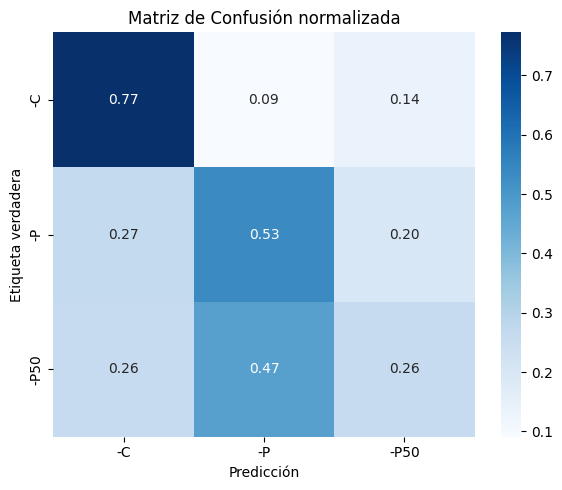

In [22]:
# Predice en el conjunto de prueba
y_pred = model.predict(X_test)

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión normalizada
cm = confusion_matrix(y_test, y_pred, normalize='true')

# Mapear indices de clases a nombres de clases
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
class_names = [idx_to_class[i] for i in range(num_classes)]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta verdadera")
plt.title("Matriz de Confusión normalizada")
plt.tight_layout()
plt.show()